## Responsivity Overview

This notebook corresponds to Section 3.2.1 of the thesis.
In the following, we visualise ROI responsivity to different stimuli.

### Step 1: Import Data and Dependencies

In [ ]:
import warnings
warnings.filterwarnings('ignore')

try:
    from openscope_databook.databook_utils.dandi_utils import dandi_stream_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

import sys
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import remfile
import h5py
import openscope_databook.databook_utils.dandi_utils

from dandi import dandiapi
from nwbwidgets import nwb2widget
import pynwb
from pynwb import NWBHDF5IO
from IPython.display import display, HTML

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate

from helpers import *

%matplotlib inline

filepath = "sub-731327_ses-2025+01+30-vsync-new_ophys.nwb"

# Use NWBHDF5IO to read the local NWB file instead of dandi_stream_open
io = NWBHDF5IO(filepath, 'r')
nwb = io.read()

graphColour = (137/255, 0/255, 225/255)

ylabel = "Mean per stimulus response ($\Delta$F/F)"
ylabel_summed = "Summed mean per stimulus response ($\Delta$F/F)"

### Step 2: Create Auxiliary Functions

In [3]:
# Computes average per stimulus responses to a stimulus type for a specified imaging plane

def get_responses_for_plane(nwb, plane, presentation_count, stim_table, shift=0.2):
    responses = []

    dff_timestamps, dff_trace = get_dff_any(nwb, plane)
    dff_trace = interpolate_dff(dff_trace, dff_timestamps, 10) #always interpolate!
    dff_timestamps = np.arange(dff_timestamps[0], dff_timestamps[-1], 1/10)

    for i in range(dff_trace.shape[1]): #for every roi
        response = 0
        traces = dff_trace[:, i]
        
        for j in range(stim_table.shape[0]): #for every stimulus
            start_time = stim_table.iloc[j]["start_time"] + shift #shift integration window
            end_time = stim_table.iloc[j]["stop_time"] + shift
            

            start_idx, end_idx = np.searchsorted(dff_timestamps, (start_time, end_time))
            response += traces[start_idx:end_idx].mean() / presentation_count #average over stimulus presentations

        responses.append(response) #append sum of all responses to all stimuli for this roi to the responses list

    responses = np.array(responses) #array that contains summed response for every roi of the plane
    
    return responses #sums of response for all rois per plane

In [4]:
# Computes and (optionally) plots average per stimulus responses of all imaging planes for a given stimulus 

def getResponsesPerStimPerPlane(nwb, stim_name, presentation_count, shift=0.2, xSize=20, ySize=10, plotRoisInPlane = False):

    all_responses = []

    planes = nwb.imaging_planes.keys()

    planes_responses = []

    stim_table = nwb.intervals[stim_name][:]

    if plotRoisInPlane:
        fig, axes = plt.subplots(4,2, figsize=(xSize,ySize))

        if stim_name == "homogeneous_background_presentations_vsync":
            fig.suptitle(f"Activity per ROI per region during {getStimName(stim_name)} stimulus")
        else:
            fig.suptitle(f"Activity per ROI per region .2s after {getStimName(stim_name)} stimulus onset")
        axes = axes.flatten()

    for ax_idx, plane in enumerate(planes):
        response_sums_in_plane = get_responses_for_plane(nwb, plane, presentation_count, stim_table, shift)
        planes_responses.append(response_sums_in_plane)

        if plotRoisInPlane:
            ax = axes[ax_idx]
            ax.plot(response_sums_in_plane, 'x', color=graphColour)
            ax.set_title(getRegionByPlane(plane))
            ax.set_xlabel("Roi No.")
            ax.set_ylabel("")
            
            fig.text(0.04, 0.5, 'Average per stimulus response ($\Delta$F/F)', va='center', ha='center', rotation='vertical', fontsize=10, fontweight="light")
            
    if plotRoisInPlane:
        plt.tight_layout(rect=[0.05, 0, 1, 1])

    all_responses.append(planes_responses)
    print(f"Successfully calculated responses to {getStimName(stim_name)}.")


    return all_responses

### Step 3: Compute Responsivity

In [5]:
all_stim_responses = []
stim_names = list(nwb.intervals.keys())[3:-1]
stim_names[0], stim_names[1] = stim_names[1], stim_names[0] #change order of stimuli (not necessary; done for order in thesis)
presentation_counts = [1, 80, 1560, 2880, 2960] #counts of how often stimuli were presented

del stim_names[3] # delete unneccessary second rdk stimulus

for i, stim in enumerate(stim_names):
    all_stim_responses.append(getResponsesPerStimPerPlane(nwb, stim, presentation_counts[i]))

Successfully calculated responses to Homogeneous Background.
Successfully calculated responses to Drifting Gratings.
Successfully calculated responses to Random Dot Kinematogram.
Successfully calculated responses to Gabor Stimuli.
Successfully calculated responses to Sparse Noise.


### Step 4: Plot Results

Homogeneous Background


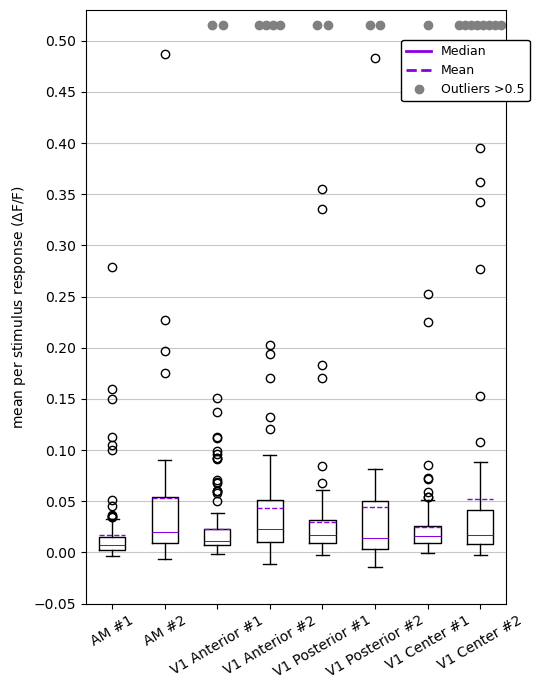

Drifting Gratings


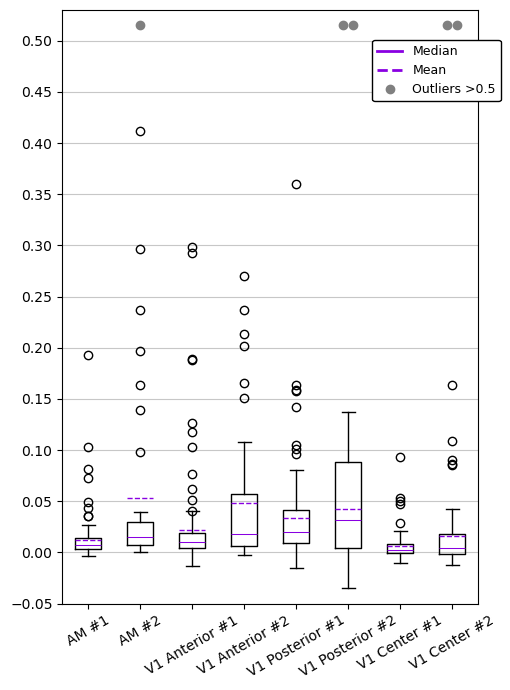

Random Dot Kinematogram


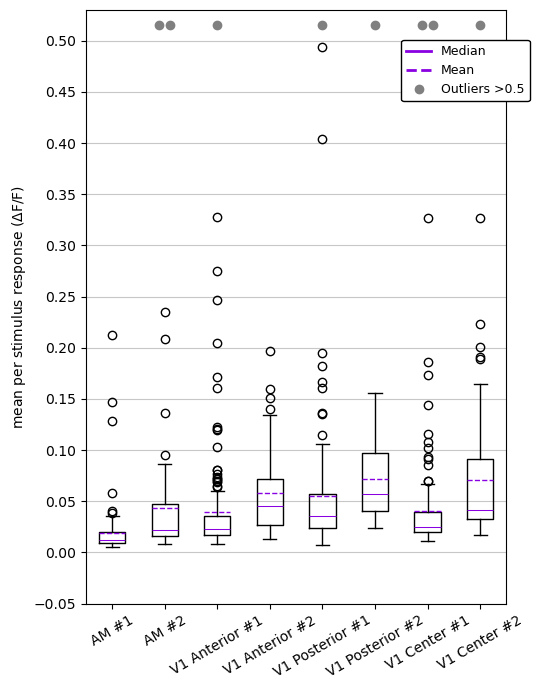

Gabor Stimuli


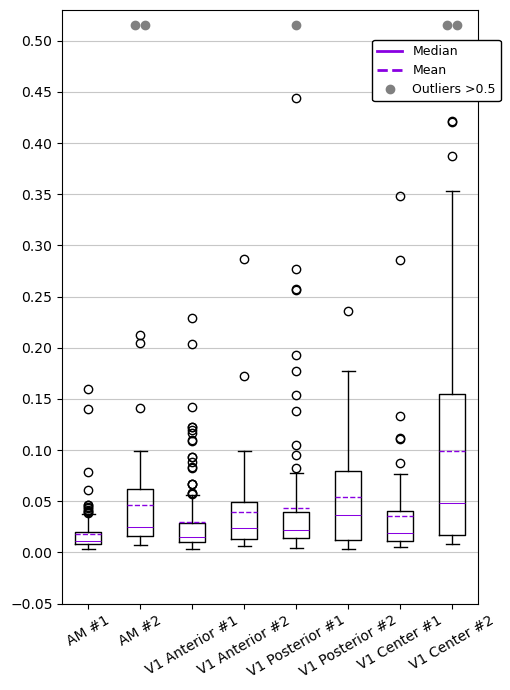

Sparse Noise


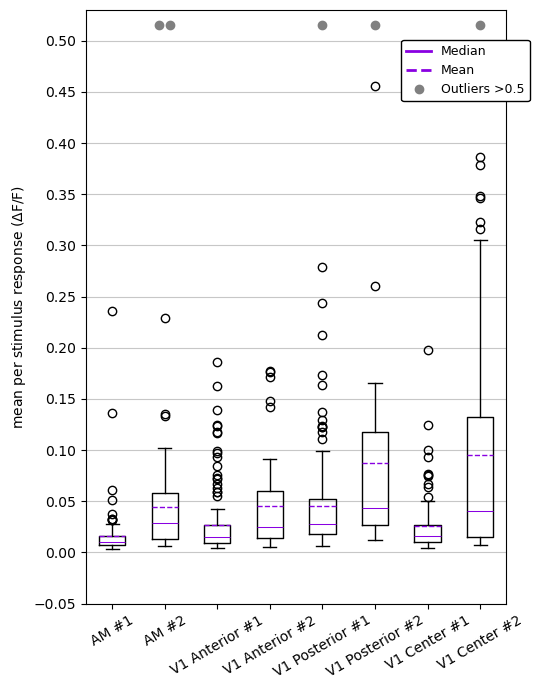

In [7]:
plane_names = ["AM #1", "AM #2", "V1 Anterior #1", "V1 Anterior #2", "V1 Posterior #1", "V1 Posterior #2", "V1 Center #1", "V1 Center #2"]
stim_names = list(nwb.intervals.keys())[3:-1]
stim_names[0], stim_names[1] = stim_names[1], stim_names[0]
del stim_names[3]

for i, planes_responses in enumerate(all_stim_responses):
    print(getStimName(stim_names[i]))
    if i in [0,2,4]:
        fig, ax = plt.subplots(figsize=(5.5,7))
    else:
        fig, ax = plt.subplots(figsize=(5.2,7))
        
    planes_responses = planes_responses[0]

    stim_name = stim_names[i]
    

    ax.set_ylim(-0.05, 0.53)

    for j in range(8): #for each plane
    
        outliers = [v for v in planes_responses[j] if v > 0.5] #define outliers above 0.5
        if len(outliers) > 0: # plot outliers       
            n_outliers = len(outliers)
            x_pos = j + 1
            y_pos = 0.515
            if n_outliers > 1:
                distance = n_outliers/10
                x_jitter = np.linspace(-distance/2, distance/2, n_outliers) + x_pos    
                y_vals = np.zeros(len(x_jitter)) + 0.515
            else:
                x_jitter = x_pos
                y_vals = y_pos
                
            ax.scatter(x_jitter, y_vals, color='grey')


    ax.set_yticks(np.arange(-0.05, 0.51, 0.05))
    ax.grid(axis='y', zorder=1, alpha=0.7)

    planes_responses_clipped = [d[d <= 0.5] for d in planes_responses]

    box = ax.boxplot(planes_responses_clipped, 
                     showmeans=True, 
                     medianprops=dict(color=graphColour, linewidth=0.75),
                     meanline=True,
                     meanprops=dict(color=graphColour, linestyle="--"), zorder=10)

    median_line = Line2D([0], [0], color=graphColour, lw=2, linestyle='-', label='Median')
    mean_line = Line2D([0], [0], color=graphColour, lw=2, linestyle='--', label='Mean')  
    outlier_dot = Line2D([0], [0], color='grey', marker='o', linestyle='', markersize=6, label='Outliers >0.5')

    ax.set_xticks(ticks=range(1, len(planes_responses)+1), labels=plane_names, rotation=30)


    if i in [0,2,4]:
        ax.set_ylabel(ylabel)
    
    # legend created with aid of ChatGPT
    ax.legend(handles=[median_line, mean_line, outlier_dot], 
              fontsize=9, loc="upper right", 
              bbox_to_anchor=(1.07, 0.96), 
              frameon=True,                    # ensure there is a frame
              edgecolor='black',               # color of the frame
              facecolor='white',               # background color
              framealpha=1                     # make the box opaque (1 = fully opaque))
              )

    plt.tight_layout()
    plt.show()

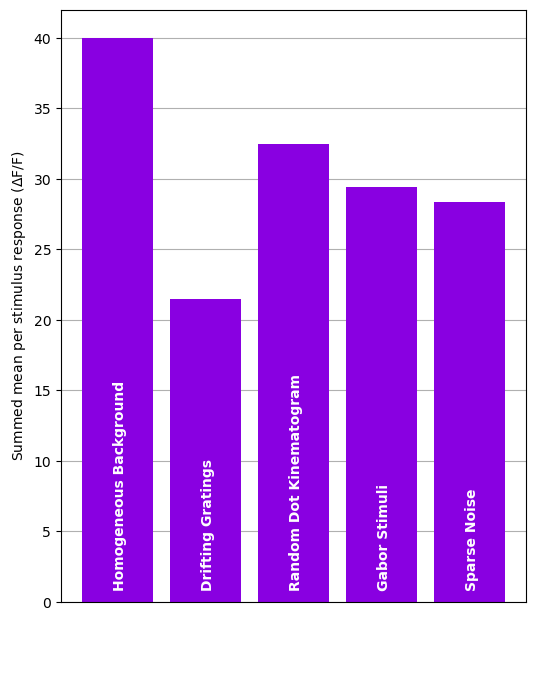

In [12]:
# For the summed aver per stimulus responses:
names = []
sums = []

for i, stim in enumerate(stim_names):
    names.append(getStimName(stim))
    activity_sum = 0
    plane_responses = all_stim_responses[i]
    for j in range(8):
        activity_sum += np.array(plane_responses[0][j]).sum()
    sums.append(activity_sum)


fig = plt.figure(figsize=(6,8.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 0.05]) 

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.bar(names, sums, color=graphColour, zorder=2)
ax1.grid(axis="y", zorder=0)

ax1.tick_params(axis='x', which='both', length=0, zorder=0)
ax1.set_xticks([])

for i in range(5):
    ax1.text(i+0.025, 0.8, names[i], rotation=90, horizontalalignment="center", verticalalignment="bottom", color="white", fontweight="bold")

ax1.set_ylabel(ylabel_summed)
ax2.axis("off")

_ = plt.show()